In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os
os.getcwd()
import sys
sys.path.append('/content/drive/MyDrive/d2l-en-master')
from d2l import torch as d2l
from sklearn.decomposition import PCA
import umap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

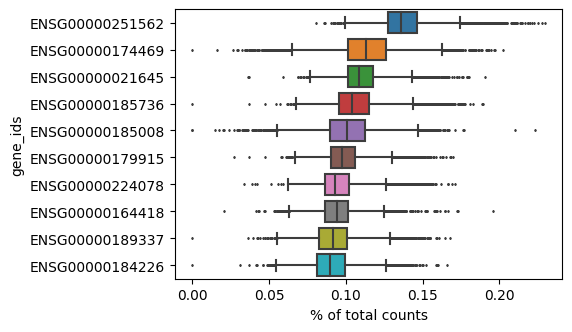

In [ ]:
#import and filter the train data
ann_40k = sc.read_h5ad("local.h5ad")
sc.pl.highest_expr_genes(ann_40k, n_top=10)

In [ ]:
#data selection
sc.pp.filter_genes(ann_40k, min_cells= 30)
sc.pp.normalize_total(ann_40k, target_sum=1e6)
sc.pp.log1p(ann_40k)
sc.pp.highly_variable_genes(ann_40k, min_mean=0.0125, max_mean=3, min_disp=0.5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


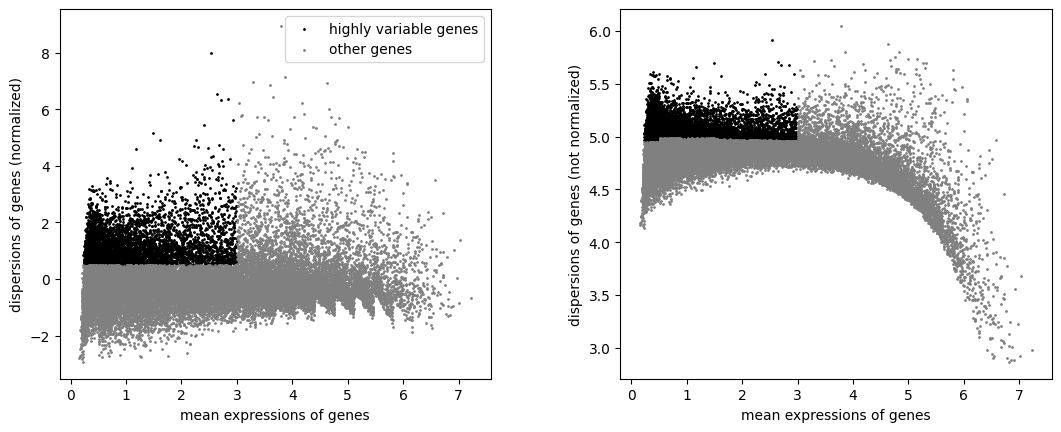

In [ ]:
sc.pl.highly_variable_genes(ann_40k)

In [ ]:
ann_40k = ann_40k[:, ann_40k.var.highly_variable]
sc.pp.scale(ann_40k,max_value = 10)

/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
ann_40k.layers["X1"] = ann_40k.X
df = ann_40k.to_df(layer="X1")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
training_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data.index)

In [ ]:
training_data

gene_ids,ENSG00000000971,ENSG00000001617,ENSG00000003096,ENSG00000003249,ENSG00000003436,ENSG00000004399,ENSG00000004776,ENSG00000004799,ENSG00000004838,ENSG00000004939,...,ENSG00000288059,ENSG00000288071,ENSG00000288085,ENSG00000288087,ENSG00000288088,ENSG00000288096,ENSG00000288098,ENSG00000288102,ENSG00000288156,ENSG00000288187
exp_component_name,,,,,,,,,,,,,,,,,,,,,
TCGGGTGCACTACTTT-L8TX_210506_01_A09-1153814215,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
AGGGCTCGTGCAGGAT-L8TX_210722_01_H06-1153814299,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
AAAGGTAAGCTGAGTG-L8TX_210805_01_F02-1153814316,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,7.604221,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
CTGAGCGTCACTTCTA-L8TX_210805_01_F02-1153814316,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
AGAGAATCAGACCTGC-L8TX_210121_01_C03-1142430372,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGCAGGTAGGATGCGT-L8TX_210429_01_C03-1142430411,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
CAGCACGTCTCTCGAC-L8TX_210226_01_A12-1142430380,-0.066766,-0.42935,3.626898,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,5.820981,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441
AGTACTGAGGTCCCGT-L8TX_210318_01_E04-1153814164,-0.066766,-0.42935,-0.283809,-0.348481,-0.078003,-0.185745,-0.109215,-0.134676,-0.09495,-0.083526,...,-0.230164,-0.137500,-0.322238,-0.0926,-0.122448,-0.130669,-0.20664,-0.101461,-0.077199,-0.1441


In [ ]:
in_train = ann_40k.obs.index.isin(training_data.index)
in_test = ann_40k.obs.index.isin(testing_data.index)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ann_40k_train = ann_40k[in_train,:]

In [ ]:
ann_40k_test = ann_40k[in_test,:]

In [ ]:
ann_40k_train

View of AnnData object with n_obs × n_vars = 7362 × 4196
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
   

In [ ]:
ann_40k_test

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


View of AnnData object with n_obs × n_vars = 1841 × 4196
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
   

In [ ]:
arr_train = ann_40k_train.X
arr_test = ann_40k_test.X
arr_train.shape,arr_test.shape

((7362, 4196), (1841, 4196))

In [ ]:
def load_data(arr_k):
    tensor1 = torch.from_numpy(arr_k)
    return tensor1

In [ ]:
class DataBuilder():

    def __init__(self,arr_k):
        self.tensor1 = load_data(arr_k)
        self.len=self.tensor1.shape[0]

    def __getitem__(self,index):
        return self.tensor1[index]

    def __len__(self):
        return self.len

In [ ]:
#build dataset
ds =DataBuilder(arr_train)
ds1 = DataBuilder(arr_test)
#load train data
trainds=DataLoader(dataset=ds,batch_size=128,shuffle = True)
tests=DataLoader(dataset=ds1,batch_size = 128)

In [ ]:
#defint parameters
in_shape = ds.tensor1.shape[1]
h1 = in_shape//2
h2 = h1//2
h3 = h2// int(h2/30)
h3

30

In [ ]:
#Build encoder & decoder

class Autoencoder(nn.Module):
    def __init__(self, in_shape,h1,h2,h3):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_shape, h1), #9129
            nn.ReLU(),
            # nn.BatchNorm1d(h1),
            nn.Dropout(0.1),
            nn.Linear(h1, h2),#2282
            nn.ReLU(),
            # nn.BatchNorm1d(h2),
            nn.Dropout(0.1),
            nn.Linear(h2, h3), #570
        )

        self.decoder = nn.Sequential(
            nn.Linear(h3, h2), #2282
            nn.ReLU(),
            # nn.BatchNorm1d(h2),
            nn.Dropout(0.1),
            nn.Linear(h2, h1), #9129
            nn.ReLU(),
            # nn.BatchNorm1d(h1),
            nn.Dropout(0.1),
            nn.Linear(h1, in_shape),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model = Autoencoder(in_shape,h1,h2,h3).to(device)

In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4196, out_features=1049, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1049, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1049, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=1049, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1049, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1049, out_features=4196, bias=True)
  )
)

In [ ]:
#model
model = Autoencoder(in_shape,h1,h2,h3).to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)###
#Loss
Loss_MSE = nn.MSELoss()
#L1
def l1_penalty(w):
    return torch.sum(torch.abs(w))
def L1(lambd):
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambd * l1_penalty(torch.cat(l1_parameters))
    return l1
#Inital the parameters
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

model.encoder.apply(init_weights);
model.decoder.apply(init_weights);

def evaluate_loss(net, data_iter, loss):
    l1 = 0
    for batch_idx, data in enumerate(data_iter):
        data = data.to(device)
        out = model(data)
        l1 += Loss_MSE(out,data).item()
    return l1/len(data_iter)

'''def normalize(X):
    mean, std, var =0,0,0
    #X = torch.from_numpy(X)
    mean, std, var = torch.mean(X), torch.std(X), torch.var(X)
    X = (X-mean)/std
    mean, std, var = torch.mean(X), torch.std(X), torch.var(X)
    return X
    #print("Mean, std and Var after normalize:\n", mean, std, var)'''


'def normalize(X):\n    mean, std, var =0,0,0\n    #X = torch.from_numpy(X)\n    mean, std, var = torch.mean(X), torch.std(X), torch.var(X)\n    X = (X-mean)/std\n    mean, std, var = torch.mean(X), torch.std(X), torch.var(X)\n    return X\n    #print("Mean, std and Var after normalize:\n", mean, std, var)'

In [ ]:
#train
def train(lambd):
    train_loss = 0
    num_epochs = 50
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[0, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for batch_idx, data in enumerate(trainds):
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            #l1 = L1(lambd)
            loss =Loss_MSE(output, data)#+ l1
            loss.backward()
            optimizer.step()
            train_loss  += loss.item()
        if epoch % 10 == 0:
            animator.add(epoch + 1,(evaluate_loss(model,trainds,Loss_MSE),
                                     evaluate_loss(model,tests,Loss_MSE)))

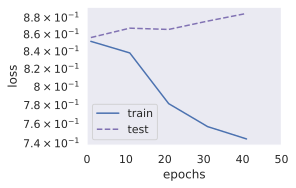

In [ ]:
train(0.001)

In [ ]:
output = []
with torch.no_grad():
        data = torch.FloatTensor(arr_train).to(device)
        encoded = model.encoder(data)
        # output.append(encoded)
        # result = torch.cat(output, dim=0)
# output = []
# with torch.no_grad():
#         data = arr_test.to(device)
#         optimizer.zero_grad()
#         encoded = model.encoder(data)
#         encoded1 = encoded
#         output.append(encoded1)
#         result1 = torch.cat(output, dim=0)
print(encoded)

tensor([[ 3.5034,  4.5054,  5.3251,  ..., -0.7060, -2.9612,  6.7457],
        [-4.4188,  5.8366,  3.9285,  ..., -1.7537, -2.6558,  1.4274],
        [-3.4154,  4.8310, -1.0068,  ..., -2.1221, -0.0202,  1.1505],
        ...,
        [-5.1257,  1.8724, -1.2644,  ..., -2.7755,  1.0699, -0.2228],
        [ 2.0044, -0.9962,  1.2792,  ...,  0.1746, -1.5993,  0.3341],
        [-2.1757,  1.6099, -1.8396,  ..., -0.5923,  0.8862,  3.3439]],
       device='cuda:0')


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


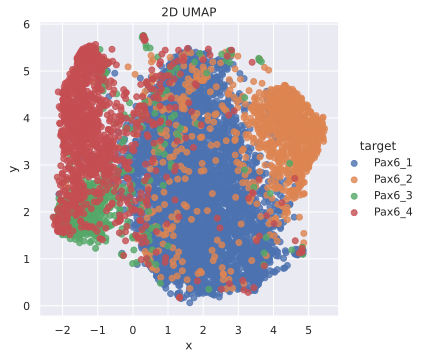

In [ ]:
UMAP = umap.UMAP()
u = UMAP.fit_transform(encoded.detach().cpu().data.numpy())
u_df = pd.DataFrame(
    data=u,
    columns=['x', 'y'])
u_df['target'] = ann_40k_train.obs.Supertype.values
import seaborn as sns
sns.set()
sns.lmplot(
    x='x',
    y='y',
    data=u_df,
    hue='target',
    fit_reg=False,
    legend=True
    )
plt.title('2D UMAP')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


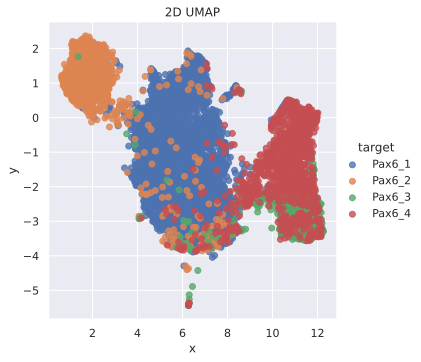

In [ ]:
import seaborn as sns
pca = PCA(n_components=30)
pca_features = pca.fit_transform(ann_40k_train.X)
pca_df = pd.DataFrame(
    data=pca_features,
    )
fit = umap.UMAP()
u = fit.fit_transform(pca_df)
u_df = pd.DataFrame(
    data=u,
    columns=['x', 'y'])
u_df['target'] = ann_40k_train.obs.Supertype.values
sns.set()
sns.lmplot(
    x='x',
    y='y',
    data=u_df,
    hue='target',
    fit_reg=False,
    legend=True
    )
plt.title('2D UMAP')
plt.show()

In [ ]:
result_num.shape,result1_num.shape

In [ ]:
ann_40k_in = ann_40k_train.obs.ADNC.to_frame()
def ANDC_to_numeric(x):
        if x=='Reference':
            return 0
        if x=='Not AD':
            return 1
        if x=='Low':
            return 2
        if x=='Intermediate':
            return 3
        if x=='High':
            return 4

ann_40k_in['ADNC_num'] = ann_40k_in['ADNC'].apply(ANDC_to_numeric)
pd.to_numeric(ann_40k_in['ADNC_num'], errors='coerce')
print(ann_40k_in)

In [ ]:
ann_40k_int = ann_40k_test.obs.ADNC.to_frame()
ann_40k_int['ADNC_num'] = ann_40k_int['ADNC'].apply(ANDC_to_numeric)
pd.to_numeric(ann_40k_int['ADNC_num'], errors='coerce')

print(ann_40k_int)

In [ ]:
ann_40k_in['ADNC_num'].value_counts()

In [ ]:
feature,labels = result_num,ann_40k_in['ADNC_num'].values
labels = list(labels)
labels = np.array(labels)
feature = load_data(feature)
labels = load_data(labels)
labels= labels.long()

feature1,labels1 = result1_num,ann_40k_int['ADNC_num'].values
labels1 = list(labels1)
labels1 = np.array(labels1)
feature1 = load_data(feature1)
labels1 = load_data(labels1)
labels1= labels1.long()

In [ ]:
feature.shape,labels.shape,feature1.shape,labels1.shape

In [ ]:
class dataset1():
    def __init__(self,X,Y):
        self.X = X                           # set data
        self.Y = Y                           # set lables

    def __len__(self):
        return len(self.X)                   # return length

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
Dataset0 = dataset1(feature,labels)
traind = DataLoader(Dataset0,batch_size=256,shuffle = True)
Dataset1 = dataset1(feature1,labels1)
testd = DataLoader(Dataset1,batch_size=256)

In [ ]:
def evaluate_loss1(net, data_iter, loss):
    l1 = 0
    for batch_idx, (x,y) in enumerate(data_iter):
        x = x.to(device)
        y = y.to(device)
        output = net(x)
        loss =Loss(output, y)
        l1 += loss.mean()
    return l1/len(data_iter)


In [ ]:
net = nn.Sequential(
    nn.Linear(262, 514),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(514, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(16, 5),


)
#layers
#先扩增128

In [ ]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
net = net.to(device)
net.apply(init_weights);

In [ ]:
num_epochs = 100
log_train = []
log_test = []
def train1():
    train_loss = 200
    num_epochs = 300
    k = 0
    for epoch in range(num_epochs):
        for batch_idx, (x,y) in enumerate(traind):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            loss =Loss(output, y)
            loss.backward()
            optimizer.step()
            train_loss  += loss
        if epoch % 10 == 0:
            log_train.append(evaluate_loss1(net,traind,Loss))
            log_test.append(evaluate_loss1(net,testd,Loss))


In [ ]:
train1()

In [ ]:
log_train1 = torch.tensor(log_train, device = 'cpu')
log_test1 = torch.tensor(log_test, device = 'cpu')
x = torch.range(10,300,10)

plt.plot(x, log_train1, label = "train")
plt.plot(x, log_test1, label = "test")
plt.legend()
plt.show()

In [ ]:
#Accuracy

In [ ]:
output1 = []
output2 = []
correct = 0
total = 0
with torch.no_grad():
    for ind,(x,y) in enumerate(testd):
        data = data.to(device)
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = net(x).cpu()
        y = y.cpu()
        _,predicted = torch.max(output,1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        output1.append(output)
        output2.append(y)
    print('Accuracy : %d %%' % (100 * correct /total))


In [ ]:
for array in output1:
    print(torch.max(array,1))


In [ ]:
output2[0]

In [ ]:
for array in output1:
    print(array[0])